<a href="https://colab.research.google.com/github/dungwoong/NN/blob/main/samdoesarts_vs_me.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

np.random.seed(2)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

import tensorflow as tf
from tensorflow import keras

from __future__ import print_function
import os

I uploaded all of my data into drive, so I mounted it here.

The data folder contained two subfolders, titled "myart" and "samdoesarts"

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The Xception model expects inputs to be 224x224, so I will resize the images. I will crop to aspect ratio and label images as 0 or 1.

In [27]:
DATASET_PATH = 'drive/MyDrive/data' # the dataset file or root folder path.
RESIZE_HEIGHT = 224
RESIZE_WIDTH = 224

In [28]:
data = keras.utils.image_dataset_from_directory(directory=DATASET_PATH,
                                                labels="inferred",
                                                label_mode="binary", # 0 and 1
                                                color_mode="rgb",
                                                batch_size=None,
                                                image_size=(RESIZE_HEIGHT, RESIZE_WIDTH),
                                                crop_to_aspect_ratio=True,
                                                shuffle=False
                                                )

Found 135 files belonging to 2 classes.


In [29]:
data.class_names

['myart', 'samdoesarts']

We will randomly flip images left/right, and use xceptions preprocess function here as well.

I will also flip the final image left/right randomly, as the orientation of these images doesn't matter and random flipping will augment the dataset

In [30]:
def preprocess(image, label):
  # size is already 400x400 so we're chillin
  final_image = keras.applications.xception.preprocess_input(image)
  final_image = tf.image.random_flip_left_right(final_image)
  return final_image, label

In [31]:
batch_size = 32
train_set = data.shuffle(1000)
train_set = train_set.map(preprocess).batch(batch_size).prefetch(1)

We load the layer, add a pooling layer(to shrink the outputs of the Xception model by a factor of 2), and add a single sigmoid activated neuron as our output layer(as this is a binary classification task)

In [32]:
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(1, activation="sigmoid")(avg) # WOO
model = keras.Model(inputs=base_model.input, outputs=output)

Freeze the model's layers

In [34]:
for layer in base_model.layers:
  layer.trainable = False

Compile and fit our additional layers(the singular neuron on the model)

In [35]:
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [36]:
history = model.fit(train_set, epochs=5)

Epoch 1/5
5/5 [==============================] - 28s 260ms/step - loss: 0.6906 - accuracy: 0.4815
Epoch 2/5
5/5 [==============================] - 25s 112ms/step - loss: 0.6556 - accuracy: 0.6148
Epoch 3/5
5/5 [==============================] - 25s 112ms/step - loss: 0.6291 - accuracy: 0.6000
Epoch 4/5
5/5 [==============================] - 25s 109ms/step - loss: 0.5920 - accuracy: 0.6889
Epoch 5/5
5/5 [==============================] - 25s 114ms/step - loss: 0.5588 - accuracy: 0.7630


In [57]:
model.save("model.h5")

In [37]:
len(base_model.layers)

132

We will continue by unfreezing some of the XCeption model's top layers and performing training at a lower learning rate

In [38]:
# we'll try unfreezing approx. the top 16 layers?

for i in range(115, len(base_model.layers)):
  base_model.layers[i].trainable = True

In [39]:
# recompile the model with a much smaller learning rate
adam_levine = tf.keras.optimizers.Adam(
    learning_rate=0.0001
)

model.compile(loss="binary_crossentropy", optimizer=adam_levine, metrics=["accuracy"])
history = model.fit(train_set, epochs=5)

Epoch 1/5
5/5 [==============================] - 28s 208ms/step - loss: 0.6086 - accuracy: 0.7111
Epoch 2/5
5/5 [==============================] - 25s 135ms/step - loss: 0.4639 - accuracy: 0.9111
Epoch 3/5
5/5 [==============================] - 25s 136ms/step - loss: 0.3723 - accuracy: 0.9630
Epoch 4/5
5/5 [==============================] - 25s 133ms/step - loss: 0.2799 - accuracy: 0.9926
Epoch 5/5
5/5 [==============================] - 25s 133ms/step - loss: 0.2158 - accuracy: 1.0000


this is how you save and load model weights

In [41]:
model.save_weights('samvme_model_weights', save_format='tf')

In [45]:
model2 = keras.models.clone_model(model)
model2.load_weights('samvme_model_weights')

In [48]:
model2.compile(loss="binary_crossentropy", optimizer=adam_levine, metrics=["accuracy"])
model2.evaluate(train_set)

5/5 [==============================] - 28s 112ms/step - loss: 0.1444 - accuracy: 0.9926


[0.14444510638713837, 0.9925925731658936]

In [49]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

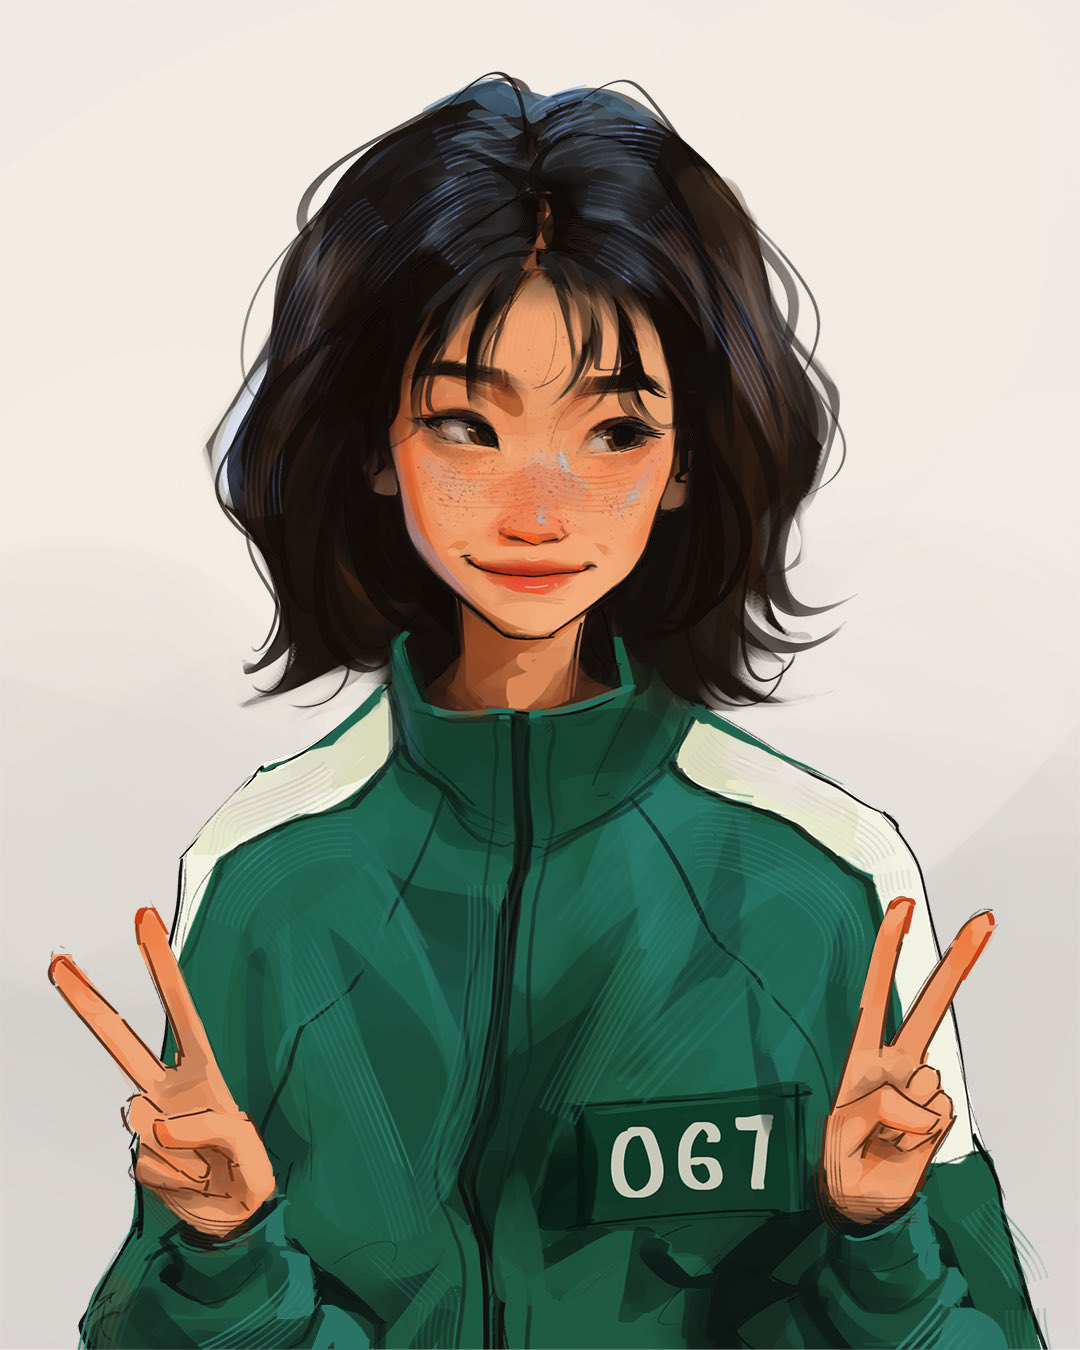

In [51]:
test_image = "4d3.jpg"
image1 = PIL.Image.open(test_image)
image1

In [69]:
print(image1.format)
print(image1.size)
print(image1.mode)

JPEG
(1080, 1350)
RGB


In [52]:
np.asarray(image1).shape

(1350, 1080, 3)

I want to write my own preprocessing/predict methods so that I can make an nice visualization. It was at this point where I realized I really shouldn't have trained my model on all of my existing art...

In [53]:
def process_image(image, xception=True): # image will be read from PIL
  image = tf.convert_to_tensor(np.asarray(image)[np.newaxis, ...])
  image = tf.image.resize(image, size=[224, 224], preserve_aspect_ratio=True)
  if xception:
    image = keras.applications.xception.preprocess_input(image)
  return image

def process_prediction(prediction): # prediction will be like [[prediction]]
  prediction = prediction.flatten()[0]
  if prediction < 0.5:
    return "me", 1 - prediction
  else:
    return "sam", prediction

In [54]:
custom_image = PIL.Image.open("sam1.jpg")
process_prediction(model.predict(process_image(image1)))

('sam', 0.7833847)

In [55]:
process_prediction(model.predict(process_image(image1)))

('sam', 0.7833847)

In [56]:
training_img = train_set.as_numpy_iterator()

In [98]:
import matplotlib.pyplot as plt

# for i in range(0, 10):
#   img = next(training_img)
#   print(img)

batch1 = next(training_img)
batch1[0].shape

(32, 224, 224, 3)

In [99]:
predictions = model.predict(batch1[0])

In [101]:
predictions.shape

(32, 1)

I re-ran this with a few of my unincluded(NSFW) art. There wasn't much art to put in, but the model was 100% accurate. However, it's outputted probabilities are low. The model is most likely(100%) overfit, considering it has 99% accuracy on the training data.

In [58]:
image1 = PIL.Image.open("sam1.jpg")
image2 = PIL.Image.open("4d3.jpg")
image3 = PIL.Image.open("20220424.png")
image4 = PIL.Image.open("20220422.png")
image5 = PIL.Image.open("sam4.jpg")
image6 = PIL.Image.open("20220518.png")
image7 = PIL.Image.open("lookinggirl2.jpg")
image8 = PIL.Image.open("02102021.png")
image9 = PIL.Image.open("12172021.jpg")
# image3 = PIL.Image.open("02272022.jpg")
# image4 = PIL.Image.open("03142022.jpg")
image_list = [image1, image2, image5, image3, image4, image6, image7, image8, image9]

My initial model was trained on all of my artwork and was able to correctly identify it. My second model was trained on my artwork up until april 2022, and is unable to identify some of my newer works. It can, however, somewhat identify old sketches that I've drawn, and an apple that I painted as practice. Interesting...

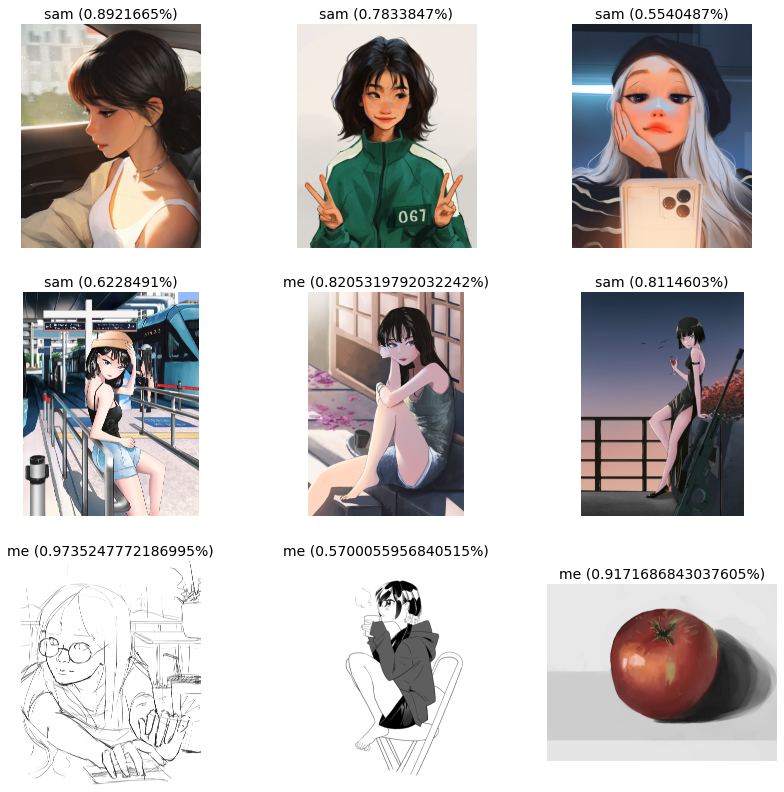

In [59]:
fig = plt.figure(figsize=(14, 14))
columns = 3
rows = 3
for i in range(0, columns*rows):
    img = image_list[i]
    fig.add_subplot(rows, columns, i+1)
    pred = model.predict(process_image(img))
    artist, prob = process_prediction(pred)
    pred_text = str(artist) + " (" + str(prob) + "%)"
    plt.title(pred_text, fontsize=14)
    plt.imshow(img)
    plt.axis('off')
plt.show()